# Pivot mult-indexing + apply

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)})
plt.style.use(['seaborn-whitegrid'])

import warnings
warnings.simplefilter('ignore')

import utils

Recap from previous notebook

In [2]:
freq = "10min"

df = pd.read_csv("data/comfort_data.csv.gz",  compression='gzip')
qry = ["solar==0",
       "days==14",
       "strategy in ['no_control', 'smooth', 'single_bucket']"]

df = df.query(" and ".join(qry))
df.timestamp = pd.to_datetime(df.timestamp)
df.shape

# limit the data a bit...
qry = ["solar==0",
       "days==14",
       "feeder=='one'",
       "control==0",
       "season=='summer'",
       "attribute=='shower demand 110'",
       "strategy in ['no_control']"]

tmp = df.query(" and ".join(qry))
tmp.timestamp = pd.to_datetime(tmp.timestamp)

## Question #2

### What is the average cumulative % of customers impacted as a function of time?

Count a customer as unsatisfied only once...

(how many phone calls with the Vermont utility get)

Warm up

In [3]:
counts = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count')
counts.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-11.366667                NaN                 NaN                 NaN   
-11.350000                NaN                 NaN                 NaN   
-11.333333                NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-11.366667               NaN                 NaN                 NaN   
-11.350000               NaN                 NaN                 NaN   
-11.333333               NaN                 NaN                 NaN   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-11.366667                 NaN         ...                         NaN   
-11.350000                 NaN         ...                         NaN   
-11.333333                 NaN         ...                         NaN   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 1.0   
-11.333333                 NaN                 NaN                 1.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 NaN                 NaN                 NaN  
-12.916667                 NaN                 NaN                 NaN  
-11.366667                 NaN                 NaN                 NaN  
-11.350000                 N

We need a function that only counts the first instance of an event (cold shower).

In [4]:
counts[1, 'zmq_waterheater_194']

shift
-12.933333   NaN
-12.916667   NaN
-11.366667   NaN
-11.350000   NaN
-11.333333   NaN
-11.316667   NaN
-11.300000   NaN
-11.200000   NaN
-11.183333   NaN
-11.166667   NaN
-11.150000   NaN
-11.133333   NaN
-11.116667   NaN
-11.100000   NaN
-11.016667   NaN
-11.000000   NaN
-10.916667   NaN
-10.900000   NaN
-10.866667   NaN
-10.850000   NaN
-10.833333   NaN
-10.816667   NaN
-10.800000   NaN
-10.783333   NaN
-10.766667   NaN
-10.750000   NaN
-10.733333   NaN
-10.716667   NaN
-10.683333   NaN
-10.666667   NaN
              ..
 8.666667    NaN
 8.683333    NaN
 8.700000    NaN
 8.716667    NaN
 8.733333    NaN
 8.750000    NaN
 8.766667    NaN
 8.866667    NaN
 9.250000    NaN
 9.266667    NaN
 9.283333    NaN
 9.983333    NaN
 10.000000   NaN
 10.016667   NaN
 10.066667   NaN
 10.250000   NaN
 10.266667   NaN
 10.283333   NaN
 10.300000   NaN
 10.316667   NaN
 10.433333   NaN
 10.516667   NaN
 10.533333   NaN
 10.600000   NaN
 10.616667   NaN
 10.866667   NaN
 10.883333   NaN
 10.9000

In [5]:
counts[1, 'zmq_waterheater_194'].first_valid_index()

-4.96666666667

In [6]:
counts[1, 'zmq_waterheater_194'].sum()

12.0

In [9]:
import numpy as np

def fill_first_index(df):
    zeros = np.zeros(df.shape[0])
    index = df.first_valid_index()

    if index is not None:
        tmp = pd.Series(zeros, index=df.index)
        tmp.loc[tmp.index==index] = 1.0
        return tmp
    
    return pd.Series(zeros, index=df.index)

In [10]:
trial = counts[1, 'zmq_waterheater_194']

trial.sum(), fill_first_index(trial).sum()

(12.0, 1.0)

We can `apply` this to the columns (`axis=0`) of our dataframe.

In [11]:
final = counts.apply(fill_first_index, axis=0)
final.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-11.366667                0.0                 0.0                 0.0   
-11.350000                0.0                 0.0                 0.0   
-11.333333                0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-11.366667               0.0                 0.0                 0.0   
-11.350000               0.0                 0.0                 0.0   
-11.333333               0.0                 0.0                 0.0   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-11.366667                 0.0         ...                         0.0   
-11.350000                 0.0         ...                         0.0   
-11.333333                 0.0         ...                         0.0   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 1.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 0.0                 0.0                 0.0  
-12.916667                 0.0                 0.0                 0.0  
-11.366667                 0.0                 0.0                 0.0  
-11.350000                 0

Check that we only have a single value per day and waterheater

In [15]:
final.sum(axis=0)

day  name               
1    zmq_waterheater_19     1.0
     zmq_waterheater_194    1.0
     zmq_waterheater_288    1.0
     zmq_waterheater_393    1.0
     zmq_waterheater_411    1.0
     zmq_waterheater_468    1.0
     zmq_waterheater_5      1.0
     zmq_waterheater_505    1.0
     zmq_waterheater_510    1.0
     zmq_waterheater_561    1.0
     zmq_waterheater_598    1.0
     zmq_waterheater_650    1.0
     zmq_waterheater_655    1.0
     zmq_waterheater_669    1.0
     zmq_waterheater_676    1.0
     zmq_waterheater_692    1.0
     zmq_waterheater_7      1.0
     zmq_waterheater_710    1.0
     zmq_waterheater_781    1.0
     zmq_waterheater_798    1.0
     zmq_waterheater_802    1.0
     zmq_waterheater_820    1.0
     zmq_waterheater_822    1.0
     zmq_waterheater_823    1.0
     zmq_waterheater_866    1.0
     zmq_waterheater_946    1.0
     zmq_waterheater_951    1.0
     zmq_waterheater_972    1.0
     zmq_waterheater_98     1.0
     zmq_waterheater_993    1.0
               

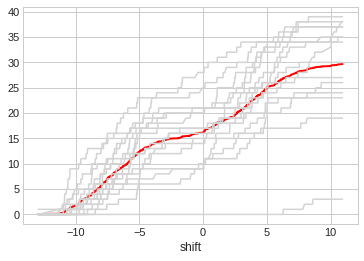

In [16]:
ax = final.sum(axis=1, level=0).cumsum().mean(axis=1).plot(lw=2, color='red')

final.sum(axis=1, level=0).cumsum().plot(legend=False, color='lightgrey', ax=ax)

Remember this number?

### Multiple Scenarios 

In [17]:
qry = ["feeder=='one'",
       "season=='summer'",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

counts = tmp.pivot_table(index='shift', 
                         columns=['feeder', 'season', 'strategy', 'control', 'day', 'name'], 
                         values='value', aggfunc='count')
counts.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                NaN                 NaN                 NaN   
-12.950000                NaN                 NaN                 NaN   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-12.466667                NaN                 NaN                 NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 NaN                 NaN                 NaN   
-12.950000                 NaN                 NaN                 NaN   
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-12.466667                 NaN                 NaN                 NaN   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               NaN                 NaN                 NaN   
-12.950000               NaN                 NaN                 NaN   
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-12.466667               NaN                 NaN                 NaN   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 NaN         ...                         NaN   
-12.950000                 NaN         ...                         NaN   
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-12.466667                 NaN         ...                         NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [21]:
first = counts.apply(fill_first_index, axis=0)
first.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                0.0                 0.0                 0.0   
-12.950000                0.0                 0.0                 0.0   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-12.466667                0.0                 0.0                 0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 0.0                 0.0                 0.0   
-12.950000                 0.0                 0.0                 0.0   
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-12.466667                 0.0                 0.0                 0.0   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               0.0                 0.0                 0.0   
-12.950000               0.0                 0.0                 0.0   
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-12.466667               0.0                 0.0                 0.0   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 0.0         ...                         0.0   
-12.950000                 0.0         ...                         0.0   
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-12.466667                 0.0         ...                         0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [22]:
first.sum(axis=1, level=[0,1,2,3,4]).cumsum().head() # why all 0 to 4?

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [22]:
first.sum(axis=1, level=[0,1,2,3,4]).cumsum().head() # why all 0 to 4?

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [27]:
first.sum(axis=1, level=[0,1,4]).cumsum().head() # for example, at minimum you'll need 0, then a list of levels to keep
# so we're summing over feeder, season, and day

feeder        one                                                              \
season     summer                                                               
day            1    2    3    4    5    6    7    8    9    26   27   28   29   
shift                                                                           
-12.966667    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
-12.950000    0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
-12.933333    0.0  0.0  0.0  0.0  0.0  0.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0   
-12.916667    0.0  0.0  0.0  0.0  0.0  0.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0   
-12.466667    0.0  0.0  0.0  1.0  0.0  0.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0   

feeder                
season                
day          30   31  
shift                 
-12.966667  0.0  0.0  
-12.950000  0.0  0.0  
-12.933333  0.0  0.0  
-12.916667  0.0  0.0  
-12.466667  0.0  0.0

In [23]:
final = first.sum(axis=1, level=[0,1,2,3,4]).cumsum().mean(axis=1, level=[0,1,2,3])

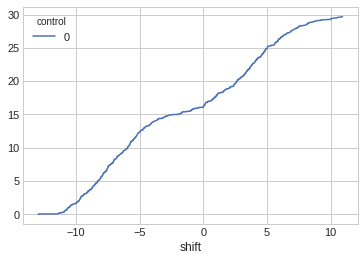

In [24]:
final[('one', 'summer', 'no_control')].plot()

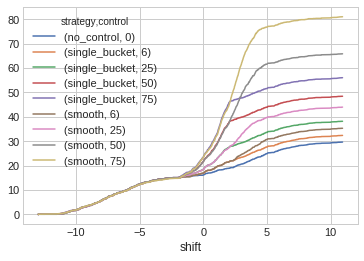

In [25]:
final[('one', 'summer')].plot()

In [30]:
final.to_csv("final.csv")
!head final.csv

feeder,one,one,one,one,one,one,one,one,one
season,summer,summer,summer,summer,summer,summer,summer,summer,summer
strategy,no_control,single_bucket,single_bucket,single_bucket,single_bucket,smooth,smooth,smooth,smooth
control,0,6,25,50,75,6,25,50,75
shift,,,,,,,,,
-12.9666666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06666666666666667
-12.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06666666666666667,0.06666666666666667
-12.933333333299998,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667
-12.916666666700001,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667
-12.4666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.13333333333333333

In [32]:
pd.read_csv("final.csv")

,feeder,one,one.1,one.2,one.3,one.4,one.5,one.6,one.7,one.8
0,season,summer,summer,summer,summer,summer,summer,summer,summer,summer
1,strategy,no_control,single_bucket,single_bucket,single_bucket,single_bucket,smooth,smooth,smooth,smooth
2,control,0,6,25,50,75,6,25,50,75
3,shift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-12.9666666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06666666666666667
5,-12.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06666666666666667,0.06666666666666667
6,-12.933333333299998,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667
7,-12.916666666700001,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667
8,-12.4666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.13333333333333333
9,-12.45,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.13333333333333333


In [33]:
import pickle

In [35]:
val = pickle.dumps(final) #does pandas have a 2-pickle method

In [36]:
type(val)

bytes

In [38]:
val

b'\x80\x03cpandas.core.frame\nDataFrame\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00_dataq\x03cpandas.core.internals\nBlockManager\nq\x04)\x81q\x05(]q\x06(cpandas.core.indexes.base\n_new_Index\nq\x07cpandas.core.indexes.multi\nMultiIndex\nq\x08}q\t(X\x06\x00\x00\x00levelsq\n]q\x0b(h\x07cpandas.core.indexes.base\nIndex\nq\x0c}q\r(X\x04\x00\x00\x00dataq\x0ecnumpy.core.multiarray\n_reconstruct\nq\x0fcnumpy\nndarray\nq\x10K\x00\x85q\x11C\x01bq\x12\x87q\x13Rq\x14(K\x01K\x01\x85q\x15cnumpy\ndtype\nq\x16X\x02\x00\x00\x00O8q\x17K\x00K\x01\x87q\x18Rq\x19(K\x03X\x01\x00\x00\x00|q\x1aNNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK?tq\x1bb\x89]q\x1cX\x03\x00\x00\x00oneq\x1datq\x1ebX\x04\x00\x00\x00nameq\x1fX\x06\x00\x00\x00feederq u\x86q!Rq"h\x07h\x0c}q#(h\x0eh\x0fh\x10K\x00\x85q$h\x12\x87q%Rq&(K\x01K\x01\x85q\'h\x19\x89]q(X\x06\x00\x00\x00summerq)atq*bh\x1fX\x06\x00\x00\x00seasonq+u\x86q,Rq-h\x07h\x0c}q.(h\x0eh\x0fh\x10K\x00\x85q/h\x12\x87q0Rq1(K\x01K\x03\x85q2h\x19\x89]q3(X\n\x00\x00\x00no_controlq4X\r\x00\x

In [39]:
pickle.loads(val)

feeder            one                                                 \
season         summer                                                  
strategy   no_control single_bucket                                    
control            0             6          25         50         75   
shift                                                                  
-12.966667   0.000000      0.000000   0.000000   0.000000   0.000000   
-12.950000   0.000000      0.000000   0.000000   0.000000   0.000000   
-12.933333   0.066667      0.066667   0.066667   0.066667   0.066667   
-12.916667   0.066667      0.066667   0.066667   0.066667   0.066667   
-12.466667   0.066667      0.066667   0.066667   0.066667   0.066667   
-12.450000   0.066667      0.066667   0.066667   0.066667   0.066667   
-11.500000   0.066667      0.066667   0.066667   0.133333   0.133333   
-11.366667   0.133333      0.133333   0.133333   0.200000   0.200000   
-11.350000   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.333333   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.316667   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.300000   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.250000   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.233333   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.216667   0.200000      0.200000   0.200000   0.266667   0.266667   
-11.200000   0.266667      0.266667   0.266667   0.333333   0.333333   
-11.183333   0.266667      0.266667   0.266667   0.333333   0.333333   
-11.166667   0.266667      0.266667   0.333333   0.400000   0.400000   
-11.150000   0.266667      0.266667   0.333333   0.400000   0.400000   
-11.133333   0.266667      0.266667   0.333333   0.400000   0.400000   
-11.116667   0.266667      0.266667   0.333333   0.400000   0.400000   
-11.100000   0.266667      0.266667   0.333333   0.400000   0.400000   
-11.016667   0.333333      0.333333   0.400000   0.533333   0.533333   
-11.000000   0.333333      0.333333   0.400000   0.533333   0.533333   
-10.933333   0.333333      0.333333   0.400000   0.533333   0.600000   
-10.916667   0.466667      0.466667   0.533333   0.666667   0.733333   
-10.900000   0.466667      0.466667   0.533333   0.666667   0.733333   
-10.866667   0.533333      0.533333   0.600000   0.733333   0.800000   
-10.850000   0.600000      0.600000   0.666667   0.800000   0.866667   
-10.833333   0.600000      0.600000   0.666667   0.800000   0.866667   
...               ...           ...        ...        ...        ...   
 8.700000   28.933333     31.666667  37.533333  47.800000  55.333333   
 8.716667   28.933333     31.666667  37.533333  47.800000  55.333333   
 8.733333   28.933333     31.666667  37.533333  47.800000  55.333333   
 8.750000   29.000000     31.733333  37.600000  47.866667  55.400000   
 8.766667   29.000000     31.733333  37.600000  47.866667  55.400000   
 8.866667   29.066667     31.800000  37.666667  47.933333  55.466667   
 9.250000   29.133333     31.866667  37.666667  47.933333  55.466667   
 9.266667   29.200000     31.933333  37.733333  48.000000  55.533333   
 9.283333   29.200000     31.933333  37.733333  48.000000  55.533333   
 9.983333   29.266667     32.000000  37.800000  48.066667  55.600000   
 10.000000  29.333333     32.066667  37.866667  48.133333  55.666667   
 10.016667  29.333333     32.066667  37.866667  48.133333  55.666667   
 10.066667  29.400000     32.133333  37.933333  48.200000  55.733333   
 10.250000  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.266667  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.283333  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.300000  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.316667  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.433333  29.466667     32.200000  38.000000  48.266667  55.800000   
 10.516667  29.533333     32.266667  38.

In [40]:
final.to_csv?